In [11]:
%load_ext autoreload
%autoreload 2

In [34]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from analysis import (keyword_color_mapping, 
                      TagPreprocessor, 
                      ClusterAnalyzer, 
                      HashtagAnalyzer, 
                      CommentPreprocessor, 
                      SentimentAnalyzer, 
                      TokenAnalyzer, 
                      TopicClassifier)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [35]:
FITSPO_Q = "fitspo|fitspiration"
BODY_POSI_Q = "bodypositive|bodypositivity"

## Hashtag Analysis
Count the most frequent hashtags, extracted from titles and descriptions of the YouTube videos.

In [24]:
# load data
df_videos = pd.read_parquet('data/preprocessed_data/video_info_details.parquet')

In [106]:
df_videos = HashtagAnalyzer().process_df(df_videos)
df_videos.to_parquet('data/preprocessed_data/video_info_details.parquet') # save the data

In [108]:
# percentage of videos with hashtags
df_videos['hashtags'].notna().sum()/len(df_videos)

0.6316082359488036

Top 10 hashtags for fitspo: [('#fitspo', 344), ('#fitness', 335), ('#fitspiration', 194), ('#workout', 172), ('#bodybuilding', 166), ('#fit', 143), ('#gym', 138), ('#fitnessmotivation', 126), ('#fitfam', 125), ('#training', 108)]
Top 10 hashtags for body positive: [('#bodypositivity', 333), ('#bodypositive', 295), ('#shorts', 84), ('#selflove', 43), ('#plussize', 27), ('#bodyimage', 26), ('#bodyart', 23), ('#dance', 20), ('#makeup', 20), ('#faceart', 17)]


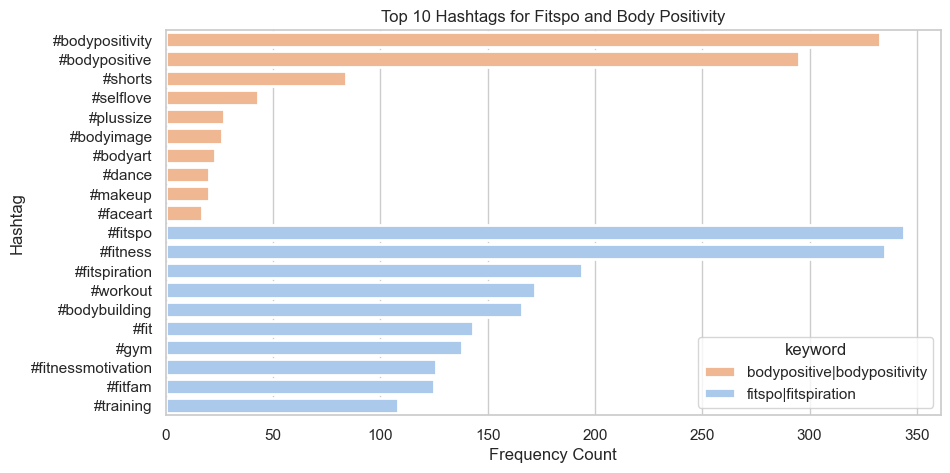

In [344]:
hashtag_count_dict = HashtagAnalyzer().plot_hashtag_counts(df_videos)

## Cluster Evaluation of Tags
Compare the two clusters of tags and evaluate the differences between them.

In [ ]:
# percentage of videos with tags
df_videos['tags'].notna().sum()/len(df_videos)

0.6193656093489148

In [213]:
df_eng = df_videos[df_videos['lang'] == 'en']
df_eng['tags'].notna().sum()/len(df_eng)

0.6082644628099173

In [271]:
tag_count_dict = TagPreprocessor().get_tag_counts(df_eng, 'tags')

In [272]:
# top 10 user-defined tags for fitspo
tag_count_dict[FITSPO_Q].most_common(10)

[('fitness', 201),
 ('fitspo', 106),
 ('motivation', 98),
 ('workout', 97),
 ('fitspiration', 92),
 ('exercise', 77),
 ('health', 63),
 ('gym', 53),
 ('fit', 48),
 ('bodybuilding', 45)]

In [273]:
# top 10 user-defined tags for body positivity
tag_count_dict[BODY_POSI_Q].most_common(10)

[('body positivity', 64),
 ('body positive', 49),
 ('plus size', 23),
 ('body', 18),
 ('positivity', 15),
 ('love', 14),
 ('self love', 14),
 ('bodypositive', 14),
 ('fat', 11),
 ('body image', 11)]

In [219]:
# deduplicate tags
tag_list_dict = ClusterAnalyzer().get_tag_lists(df_eng, deduplicate=True)

In [221]:
print(f"The number of unique tags for {FITSPO_Q} is: {len(tag_list_dict[FITSPO_Q])}")
print(f"The number of unique tags for {BODY_POSI_Q} is: {len(tag_list_dict[BODY_POSI_Q])}")

The number of unique tags for fitspo|fitspiration is: 4298
The number of unique tags for bodypositive|bodypositivity is: 1648


In [222]:
embeddings_dict = ClusterAnalyzer().get_embeddings_dict(df_eng)

In [223]:
embeddings_dict[FITSPO_Q].shape

(4298, 384)

In [224]:
embeddings_dict[BODY_POSI_Q].shape

(1648, 384)

In [227]:
# evaluate cluster distances
distance_dict = ClusterAnalyzer().evaluate_group_distance(embeddings_dict)
distance_dict

Fitspo group has tighter clustering.


{'fitspo|fitspiration': 0.9120214,
 'bodypositive|bodypositivity': 0.914389,
 'inter_group_distance': 0.13698815}

In [236]:
# Values near 0 indicate overlapping clusters.
silhouette_avg, silhouette_samples_values = ClusterAnalyzer().compute_silhouette_score(embeddings_dict)
print(f"The average silhouette_score is : {silhouette_avg}")

The average silhouette_score is : 0.0065737152472138405


In [239]:
silhouette_val_dict = ClusterAnalyzer().process_silhouette_vals(silhouette_samples_values, tag_list_dict)
df_silhouette_fitspo = silhouette_val_dict[FITSPO_Q]
df_silhouette_body_posi = silhouette_val_dict[BODY_POSI_Q]

In [240]:
df_silhouette_fitspo['silhouette_score'].sort_values(ascending=False).head(10)

fitness workout           0.051760
fitness female workout    0.049603
fitness girl workout      0.048854
female fitness workout    0.048295
fitness girls workout     0.048207
gym workout               0.047617
gym girl workout          0.045722
workout gym               0.045529
female fitness gym        0.045051
gym workouts              0.044530
Name: silhouette_score, dtype: float32

In [242]:
df_silhouette_fitspo['silhouette_score'].sort_values(ascending=False).tail(10)

positivity        -0.022993
selfie            -0.023174
love yourself     -0.023433
beauty            -0.023456
fashion           -0.024554
self care         -0.024785
goth              -0.025948
body shaming      -0.026000
self esteem       -0.029890
body positivity   -0.031647
Name: silhouette_score, dtype: float32

In [244]:
df_silhouette_body_posi['silhouette_score'].sort_values(ascending=False).head(10)

body positivity and self love    0.031700
body positivity                  0.030834
body positivity & self love      0.030818
body positivity and self care    0.029736
body negativity                  0.029593
body image and self esteem       0.029287
body positivity cringe           0.029087
self esteem                      0.029075
low self esteem                  0.028568
poor self image                  0.028171
Name: silhouette_score, dtype: float32

In [245]:
df_silhouette_body_posi['silhouette_score'].sort_values(ascending=False).tail(10)

pole fitness          -0.030723
personal trainer      -0.033123
total gym             -0.033430
exercise equipment    -0.033823
weight loss workout   -0.034428
pure gym              -0.035739
workout               -0.037342
fitness enthusiast    -0.037418
workout routines      -0.040956
fitness               -0.042426
Name: silhouette_score, dtype: float32

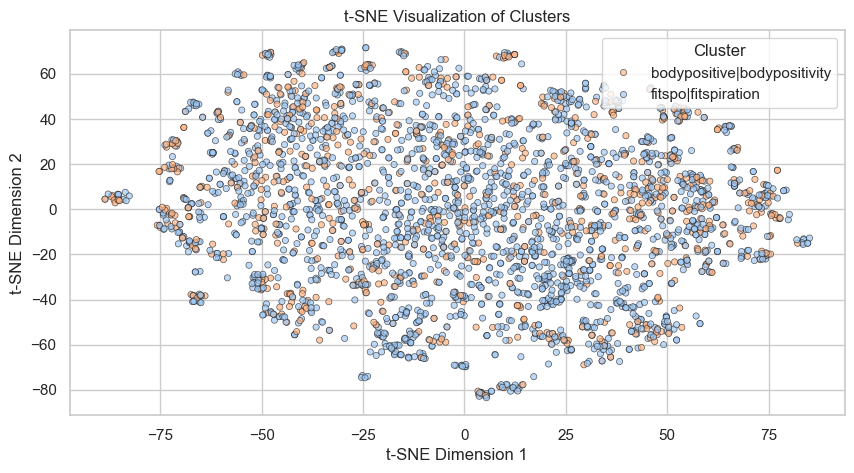

In [296]:
# visualize clusters
ClusterAnalyzer().plot_clusters(embeddings_dict)

## Comment Analysis

In [31]:
df_comments = CommentPreprocessor().process_df(rerun=True, save=True)
df_comments.head()

,comment_id,text,comment_published_at,like_count,video_id,num_comments,keyword,lang
0,UgyPI5QsDXr7wmUUvKt4AaABAg,"After 5 years, this is still my favorite motiv...",2018-10-01T16:21:08Z,42,nhRzkGpdQdk,100,fitspo|fitspiration,en
1,UgjqhVSXlEHs-ngCoAEC,success really is a journey. Been hitting the ...,2014-10-08T10:31:17Z,55,nhRzkGpdQdk,100,fitspo|fitspiration,en
2,Ughwdk3IOKhBf3gCoAEC,"I watch this whenever I feel unmotivated, and ...",2013-11-16T20:46:57Z,40,nhRzkGpdQdk,100,fitspo|fitspiration,en
3,Ugh0d-7x5OwuZngCoAEC,This is a motivational video! Strong women bei...,2016-01-17T01:54:14Z,30,nhRzkGpdQdk,100,fitspo|fitspiration,en
4,UgyPSoWbZoSYeNvs4eh4AaABAg,Love this video I watched this video 6 years a...,2022-05-26T04:14:29Z,4,nhRzkGpdQdk,100,fitspo|fitspiration,en


### Descriptive Stats

In [32]:
df_comments['keyword'].value_counts()

keyword
bodypositive|bodypositivity    23157
fitspo|fitspiration            12281
Name: count, dtype: int64

In [34]:
df_comments[df_comments['lang']=='en']['keyword'].value_counts()

keyword
bodypositive|bodypositivity    13776
fitspo|fitspiration             7997
Name: count, dtype: int64

In [8]:
13776/23157

0.5948957118797772

,keyword,video_id,count
0,bodypositive|bodypositivity,-0eCYjdtHyQ,8
1,bodypositive|bodypositivity,-lYOkTO48t0,1
2,bodypositive|bodypositivity,-t6Bmg35J_s,100
3,bodypositive|bodypositivity,006z_eFHIWw,100
4,bodypositive|bodypositivity,0AIg07BkdNk,12
...,...,...,...
753,fitspo|fitspiration,zgzISAcRvC0,12
754,fitspo|fitspiration,zi__0svHq5Y,1
755,fitspo|fitspiration,zpgw-fJUh64,19
756,fitspo|fitspiration,zpsGcHOgn70,3


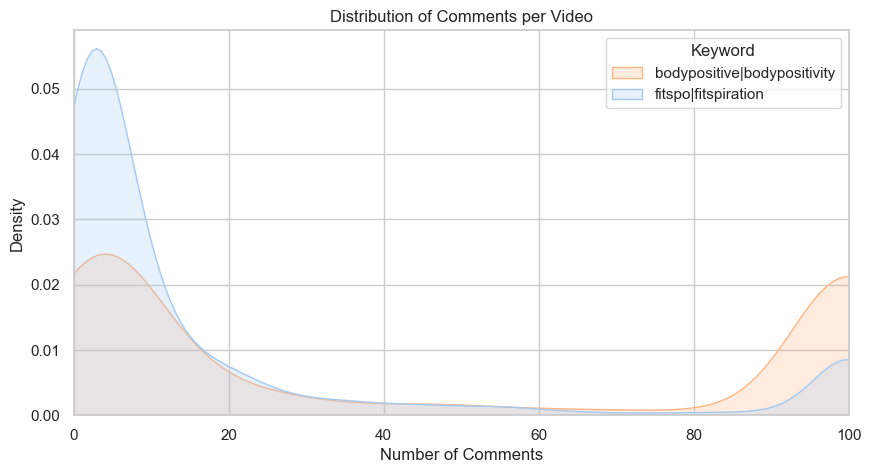

In [492]:
CommentPreprocessor().get_comment_distribution()

### Sentiment Analysis

In [ ]:
# this takes a while to run
# saved to 'data/preprocessed_data/comment_info.parquet'
df_comments = SentimentAnalyzer().add_sentiment()

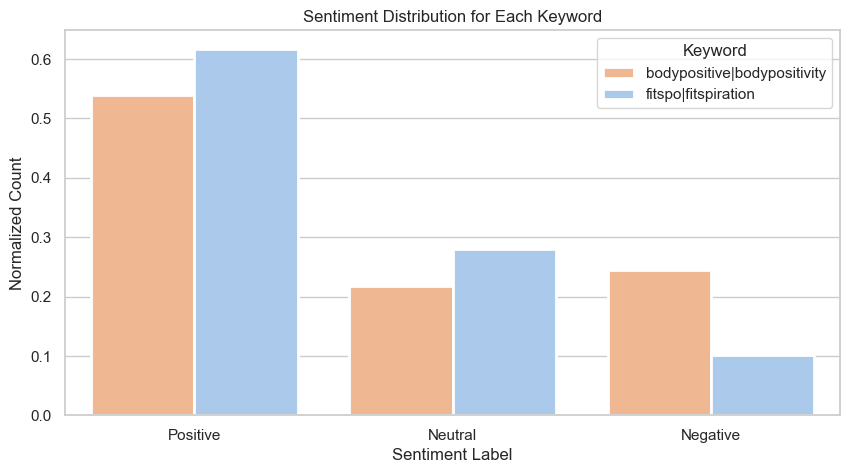

In [489]:
df_comments_summary = SentimentAnalyzer().get_sentiment_summary()

In [490]:
df_comments_summary

,keyword,sentiment_label,normalized_count
0,bodypositive|bodypositivity,positive,0.539271
1,bodypositive|bodypositivity,negative,0.243830
2,bodypositive|bodypositivity,neutral,0.216899
3,fitspo|fitspiration,positive,0.617548
4,fitspo|fitspiration,neutral,0.280840
5,fitspo|fitspiration,negative,0.101612


In [142]:
# convert sentiment to numeric, positive sentiment is 1, negative sentiment is -1, neutral sentiment is 0
df_comments['sentiment_label_num'] = df_comments['sentiment_label'].map({'positive': 1, 'negative': -1, 'neutral': 0})

# Mann-Whitney U test
stat, p = mannwhitneyu(df_comments[df_comments['keyword'] == FITSPO_Q]['sentiment_label_num'].dropna(), 
                       df_comments[df_comments['keyword'] == BODY_POSI_Q]['sentiment_label_num'].dropna())
print(f"Statistics={stat}, p={p}")

Statistics=61943750.0, p=2.6566067843292996e-66


### Bigrams Analysis

[nltk_data] Downloading package punkt to /Users/206780351/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/206780351/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/206780351/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


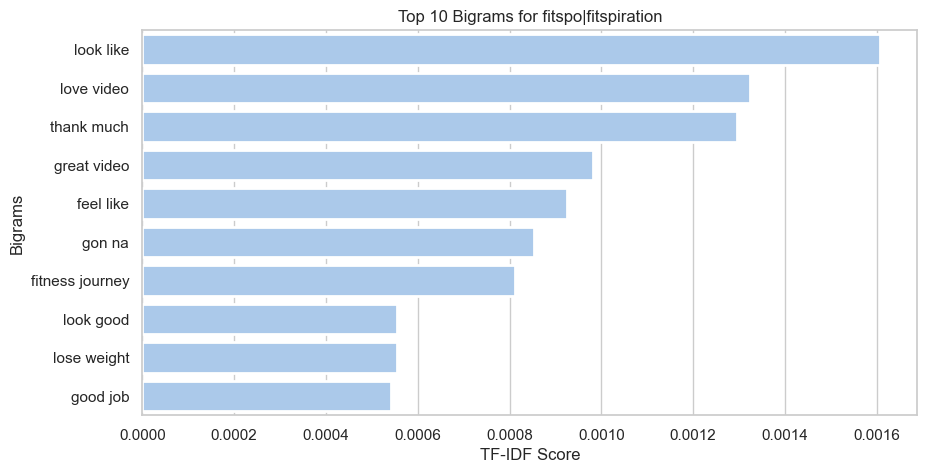

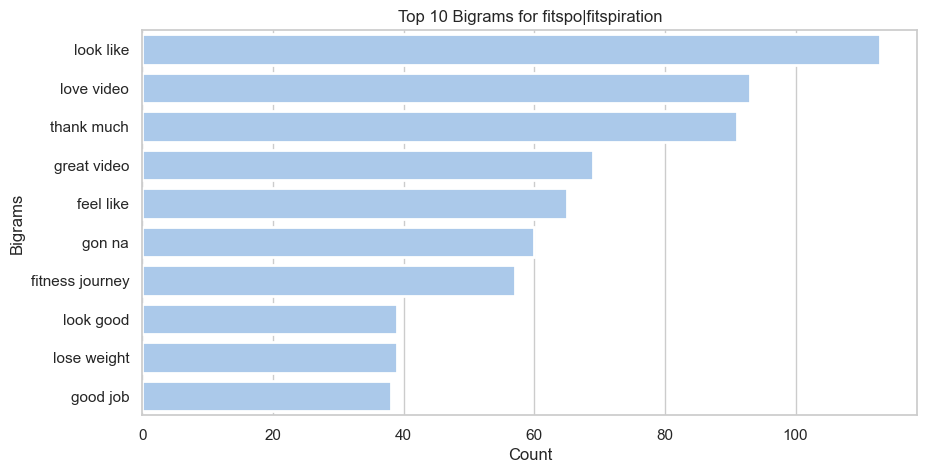

In [70]:
df_bigrams_fitspo = TokenAnalyzer().get_top_ngrams(ngram=2, keyword=FITSPO_Q)

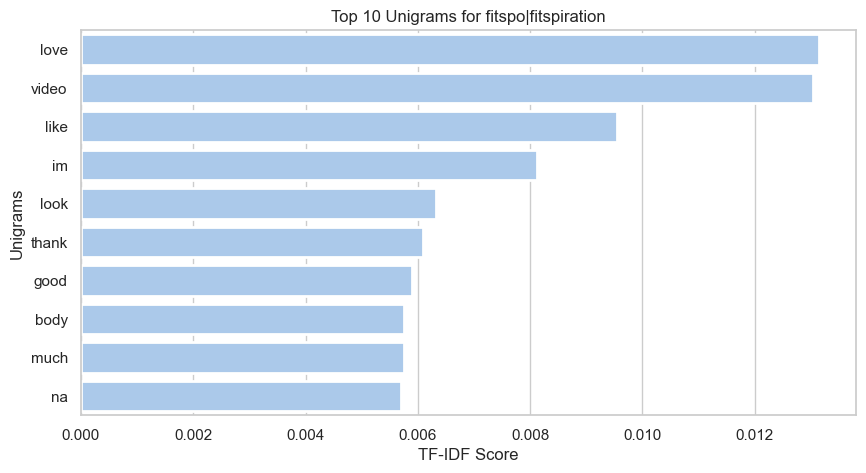

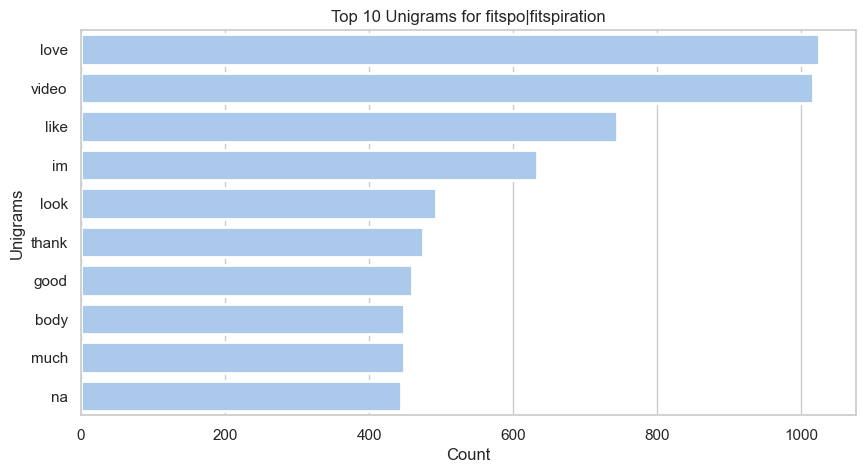

In [71]:
df_unigrams_fitspo = TokenAnalyzer().get_top_ngrams(ngram=1, keyword=FITSPO_Q)

In [ ]:
df_bigrams_bodypo = TokenAnalyzer().get_top_ngrams(ngram=2, keyword=BODY_POSI_Q)

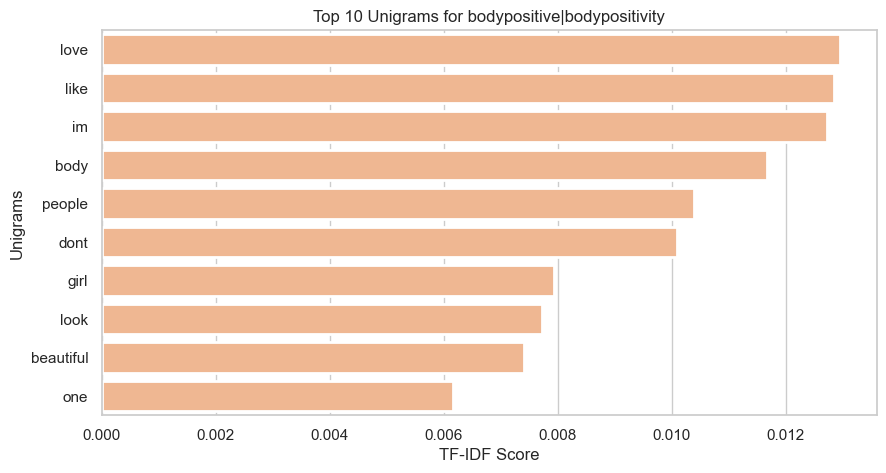

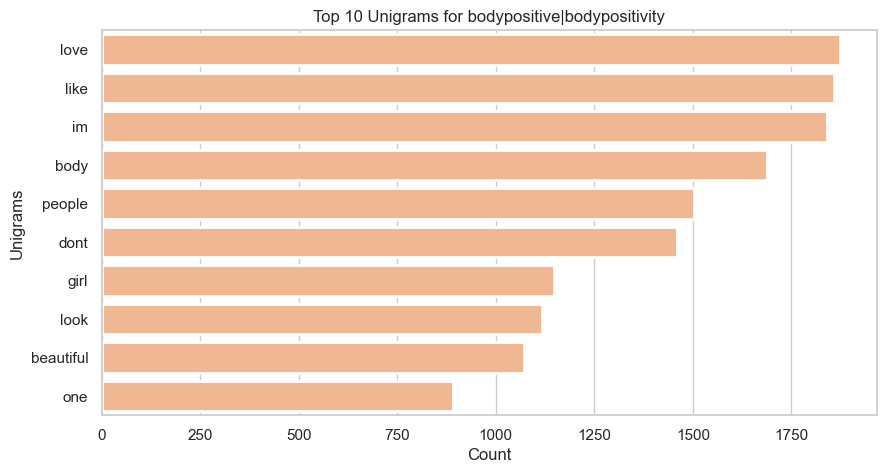

In [4]:
df_unigrams_bodypo = TokenAnalyzer().get_top_ngrams(ngram=1, keyword=BODY_POSI_Q)

### Topic Analysis

In [3]:
# load data
df_comments = pd.read_parquet('data/preprocessed_data/comment_info.parquet')

#### Qualitative Analysis of Topics

In [101]:
df_comments[df_comments['keyword'] == FITSPO_Q]['text'].sample(30, random_state=42).values

array(['Ningka vera levalu', 'i am inspired to get fit now',
       'lovely video x',
       'Another Great Mix, 🔥💯Great Choice of Hot Tracks and Thrilling Atmosphere.\nGreat addition to Your Mix Collection and Motivation for Workouts. 🏃\u200d♀🏋',
       'If this did work then you should be doing one set of one rep to failure',
       "You're 🔥🔥🔥🔥🔥 i love your Instagram pics",
       'Pretty impressive being able to move that much weight man ! I don’t believe you hit 90 though. I’d do something similar like that with 500 but maybe just try lifting it off to get you cns used to the weight so you can hit 90 in the future !!',
       'just watching her doing this gets me exhausted 😂😂',
       'They made a documentary about his shoulders',
       'That rose color of your top is really pretty on you',
       'Are those 45 Lbs plates or 35?',
       'You go boy!!! You are the word "INSPIRATION"!! AND  I DARE ANYONE TO RANK AMERICAN ANTHEM....I SO VERY MUCH VERY MUCH LOVE THAT MOVIE... IT WIL

In [102]:
df_comments[df_comments['keyword'] == BODY_POSI_Q]['text'].sample(30, random_state=42).values

array(['Couple goals! You guys are soooo cute and help me love myself for being me❤❤❤',
       'For the ones saying "life is too short to exercise", tell them "exercise to make it longer"🙂',
       'Explanation for those who have no idea what’s going on:\n\n1st one: The message probably had some inappropriate pictures…doesn’t need that much explanation ig?\n\n2nd one: When girls are on period, they need to change their pads / tampons regularly, but some teachers (especially male) doesn’t allow. So that is why girls have to go anyway.\n\n3rd one: Girls are especially insecure of their body. These are more likely for teens. This means that they go on a diet, and grab only diet coke even they are hungry.\n\n4th one: Many social media have “perfect body” pics, especially instagram. Girls are pressured by those pics and constantly compares those “perfect body” and thier body.',
       'I love how she’s talking abt Spencer’s insecurities.    Wow having friends must be so nice hahah',
       

#### Example of Zero-shot Classification

In [50]:
fitspo_example_text ="""where are your hoop earrings from?,
feels so good to feel yourself. when a person feels themselves the way I like, they lift up other people whether they know it or not. I know this girl know she lifts us all up. so cool. we love you! we know you don't do it for us !!!!!!! ugh so good <3
Yet you wear all of Guzmans gear who tells people how much better it is to be shredded and says he feels fat while he has visible abs
The broad line is, Figure out what's best for yourself. You don't have to blindly follow one fitness influencer for your entire life, you can always switch to someone else if you feel like, and that's the advantage about self training. Have a little brain people!
LOVE you and Leo so much !!! you two make a great duo and are hilarious!
I want to know how big those biceps are! Impressive flex
Great advice! I appreciate your honesty and how responsible/careful you were with the things you said in the video as I’m sure a lot of young girls are looking up to you.
The marines have strength and endurance, the influencers have speed and technique. Overall a great competition and combination
I love the realness if thats a word hahah because it seems that everyone is focused on calories and thats the only way of getting results. So seeing you say you dont track you just eat is so refreshing honestly. Thank you for sharing and motivating us <3""".split('\n')

bopo_example_text = """Listen weight, race, skin color  preference is your choice. Finding passive aggressive ways to shame girls instead of just saying no thanks is all sorts of wrong. Just use your eyes.
I'm relatively fit due to my consistent resistant training program, but maintaining it is at extremely hard. I can't see myself keeping up with a training program in the future because of all the stresses of catching up on work and potential family (Most Americans). Although we should view health as an importance, that shouldn't mean we should discriminate and bully people who are overweight.
Advocationg being very overweight to obese is healthy, is down right criminal. People actually die because of those reasons. Should you be ashamed of being fat? No. Is it a lot healthier to not be (without of course going to the other extreme)? Yes. P.S. Ela, if you want the exercise program I am using now, let me know in a PM (would feel strange just advertising it here).
Yup, I’m 6’4 when I wake up, 6’2 when I go to bed😜
Why would you hate yourself, you are absolutely gorgeous and God willing if anyone calls you anything less than that then they are idiots
Did you just make this to feel better about yourself?
No matter how you look, you will always be loved❤
Y’all act like she can’t talk about body positivity just because she shaves. I shave and I still talk about positivity. It’s not your body and she can do what she wants.
That's okay! My dad wasn't at my wedding either, but an uncle figure came and it was great ❤️
We must stay focused brothers
Still watch these every day
💗💗💗👏👏
I've dropped 80+ pounds from my top weight with another 120 to go. For every pound lost you reduce 6lbs of stress off your knees. I was in relatively good shape until I turned 48. Lose the weight before it damages your body. Your future self will thank you.
To anyone who sees this, don’t try to change your body if you don’t want to. I’ve heard stories from people who changed themselves and they said they were much happier before.""".split('\n')

In [56]:
# construct a example dataframe with keyword and text
example_df = pd.DataFrame({'keyword': [FITSPO_Q]*len(fitspo_example_text) + [BODY_POSI_Q]*len(bopo_example_text), 'text': fitspo_example_text + bopo_example_text})
df_test = TopicClassifier().add_comment_topic(df=example_df, save=False)
# find the label of maximum score across all labels
df_test['prominent_label'] = df_test.iloc[:, 2:].idxmax(axis=1)
df_test.to_excel('data/preprocessed_data/example_comment_topic_classification.xlsx', index=False)

Processing row 0...


#### Zero-shot Theme Classification for the Entire Dataset

In [ ]:
# DO NOT RUN: Takes a long time
df_comments = TopicClassifier().add_comment_topic('data/preprocessed_data/topic_cache.parquet', save=True)

In [10]:
df_comments = pd.read_parquet(TopicClassifier().topic_results_path)

In [11]:
print(f"Comments without a topic label: {df_comments[TopicClassifier().comment_candidate_labels[1]].isna().sum()}")

Comments without a topic label: 0


In [13]:
# find the label of maximum score across all labels
df_comments['prominent_label'] = df_comments.iloc[:, -10:].idxmax(axis=1)

In [14]:
# decide on the threshold for valid labels
# count the number of labels with a value greater than 0.15
df_comments.iloc[:, -11:-1].gt(0.15).sum(axis=1).value_counts()

2    9893
1    9348
3    2292
4     149
0      89
5       2
Name: count, dtype: int64

In [15]:
# for each column, if the value > 0.15, set to 1, else 0
df_comments.iloc[:, -11:-1] = (df_comments.iloc[:, -11:-1] > 0.15).astype(int)

##### Percentage of each label being prominent

In [20]:
# rank the prominent labels by the number of comments
df_comments['prominent_label'].value_counts()

prominent_label
Gratitude or Appreciation for Content         9730
Physical Appearance or Body Shape/Parts       7865
Motivational Quotes                           1010
Personal Life Stories                          963
Encouragement of Body Acceptance               715
Conceptualize Beauty Broadly                   645
Body Functionality or Physical Performance     469
Advertisement or Commercialism                 178
Weight Loss/Body Transformation                112
Dieting/Calorie Count                           86
Name: count, dtype: int64

In [16]:
df_prominent_label = df_comments.groupby(['keyword', 'prominent_label']).size().reset_index(name='count')
df_prominent_label['total_count'] = df_prominent_label.groupby('keyword')['count'].transform('sum')
df_prominent_label['percentage'] = df_prominent_label['count']/df_prominent_label['total_count']
df_prominent_label = df_prominent_label.sort_values(['keyword', 'percentage'], ascending=[True, False])
df_prominent_label

,keyword,prominent_label,count,total_count,percentage
5,bodypositive|bodypositivity,Gratitude or Appreciation for Content,5525,13776,0.401060
8,bodypositive|bodypositivity,Physical Appearance or Body Shape/Parts,5213,13776,0.378412
7,bodypositive|bodypositivity,Personal Life Stories,834,13776,0.060540
6,bodypositive|bodypositivity,Motivational Quotes,706,13776,0.051249
4,bodypositive|bodypositivity,Encouragement of Body Acceptance,651,13776,0.047256
2,bodypositive|bodypositivity,Conceptualize Beauty Broadly,526,13776,0.038182
1,bodypositive|bodypositivity,Body Functionality or Physical Performance,153,13776,0.011106
0,bodypositive|bodypositivity,Advertisement or Commercialism,75,13776,0.005444
9,bodypositive|bodypositivity,Weight Loss/Body Transformation,67,13776,0.004864
3,bodypositive|bodypositivity,Dieting/Calorie Count,26,13776,0.001887


In [22]:
# for each prominent label, get the sentiment distribution per topic
df_sentiment = df_comments.groupby(['sentiment_label', 'prominent_label', 'keyword']).size().reset_index(name='count')
df_sentiment['total_count'] = df_sentiment.groupby(['keyword', 'prominent_label'])['count'].transform('sum')
df_sentiment['percentage'] = df_sentiment['count']/df_sentiment['total_count']
df_sentiment = df_sentiment.sort_values(['sentiment_label', 'prominent_label', 'keyword'], ascending=[False, False, False])
df_sentiment

,sentiment_label,prominent_label,keyword,count,total_count,percentage
58,positive,Weight Loss/Body Transformation,fitspo|fitspiration,27,45,0.600000
57,positive,Weight Loss/Body Transformation,bodypositive|bodypositivity,24,67,0.358209
56,positive,Physical Appearance or Body Shape/Parts,fitspo|fitspiration,1096,2652,0.413273
55,positive,Physical Appearance or Body Shape/Parts,bodypositive|bodypositivity,1907,5213,0.365816
54,positive,Personal Life Stories,fitspo|fitspiration,41,129,0.317829
53,positive,Personal Life Stories,bodypositive|bodypositivity,146,834,0.175060
52,positive,Motivational Quotes,fitspo|fitspiration,197,304,0.648026
51,positive,Motivational Quotes,bodypositive|bodypositivity,371,706,0.525496
50,positive,Gratitude or Appreciation for Content,fitspo|fitspiration,3297,4205,0.784067
49,positive,Gratitude or Appreciation for Content,bodypositive|bodypositivity,4277,5525,0.774118


In [87]:
label_rank = df_comments['prominent_label'].value_counts().index

label = label_rank
f_percent_pos_lst = []
f_percent_neg_lst = []
b_percent_pos_lst = []
b_percent_neg_lst = []
for label in label_rank:
    f_percent_pos = df_sentiment[(df_sentiment['sentiment_label']=='positive') & (df_sentiment['keyword']==FITSPO_Q) & (df_sentiment['prominent_label']==label)]['percentage'].values
    f_percent_neg = df_sentiment[(df_sentiment['sentiment_label']=='negative') & (df_sentiment['keyword']==FITSPO_Q) & (df_sentiment['prominent_label']==label)]['percentage'].values
    b_percent_pos = df_sentiment[(df_sentiment['sentiment_label']=='positive') & (df_sentiment['keyword']==BODY_POSI_Q) & (df_sentiment['prominent_label']==label)]['percentage'].values
    b_percent = df_sentiment[(df_sentiment['sentiment_label']=='negative') & (df_sentiment['keyword']==BODY_POSI_Q) & (df_sentiment['prominent_label']==label)]['percentage'].values
    f_percent_pos_lst.append(f_percent_pos[0] if len(f_percent_pos) > 0 else 0)
    f_percent_neg_lst.append(f_percent_neg[0] if len(f_percent_neg) > 0 else 0)
    b_percent_pos_lst.append(b_percent_pos[0] if len(b_percent_pos) > 0 else 0)
    b_percent_neg_lst.append(b_percent[0] if len(b_percent) > 0 else 0)

df = pd.DataFrame({'Prominent Theme': label_rank, 'Percentage Positive in Fitspiration': f_percent_pos_lst, 'Percentage Positive in Body Positivity': b_percent_pos_lst, 'Percentage Negative in Fitspiration': f_percent_neg_lst, 'Percentage Negative in Body Positivity': b_percent_neg_lst})
df

,Prominent Theme,Percentage Positive in Fitspiration,Percentage Positive in Body Positivity,Percentage Negative in Fitspiration,Percentage Negative in Body Positivity
0,Gratitude or Appreciation for Content,0.784067,0.774118,0.032818,0.085068
1,Physical Appearance or Body Shape/Parts,0.413273,0.365816,0.184389,0.350086
2,Motivational Quotes,0.648026,0.525496,0.098684,0.254958
3,Personal Life Stories,0.317829,0.175060,0.348837,0.539568
4,Encouragement of Body Acceptance,0.781250,0.714286,0.000000,0.118280
5,Conceptualize Beauty Broadly,0.310924,0.285171,0.319328,0.500000
6,Body Functionality or Physical Performance,0.411392,0.464052,0.120253,0.196078
7,Advertisement or Commercialism,0.436893,0.186667,0.194175,0.480000
8,Weight Loss/Body Transformation,0.600000,0.358209,0.133333,0.238806
9,Dieting/Calorie Count,0.283333,0.153846,0.150000,0.461538


In [158]:
df_sentiment[df_sentiment["prominent_label"]=='Physical Appearance or Body Shape/Parts']

,keyword,prominent_label,sentiment_label,count,total_count,percentage
55,fitspo|fitspiration,Physical Appearance or Body Shape/Parts,positive,1096,2652,0.413273
26,bodypositive|bodypositivity,Physical Appearance or Body Shape/Parts,positive,1907,5213,0.365816
54,fitspo|fitspiration,Physical Appearance or Body Shape/Parts,neutral,1067,2652,0.402338
25,bodypositive|bodypositivity,Physical Appearance or Body Shape/Parts,neutral,1481,5213,0.284097
24,bodypositive|bodypositivity,Physical Appearance or Body Shape/Parts,negative,1825,5213,0.350086
53,fitspo|fitspiration,Physical Appearance or Body Shape/Parts,negative,489,2652,0.184389


In [160]:
df_sentiment[df_sentiment["prominent_label"]=='Body Functionality or Physical Performance']

,keyword,prominent_label,sentiment_label,count,total_count,percentage
5,bodypositive|bodypositivity,Body Functionality or Physical Performance,positive,71,153,0.464052
35,fitspo|fitspiration,Body Functionality or Physical Performance,positive,130,316,0.411392
34,fitspo|fitspiration,Body Functionality or Physical Performance,neutral,148,316,0.468354
4,bodypositive|bodypositivity,Body Functionality or Physical Performance,neutral,52,153,0.339869
3,bodypositive|bodypositivity,Body Functionality or Physical Performance,negative,30,153,0.196078
33,fitspo|fitspiration,Body Functionality or Physical Performance,negative,38,316,0.120253


In [159]:
df_sentiment[df_sentiment["prominent_label"]=='Conceptualize Beauty Broadly']

,keyword,prominent_label,sentiment_label,count,total_count,percentage
38,fitspo|fitspiration,Conceptualize Beauty Broadly,positive,37,119,0.310924
8,bodypositive|bodypositivity,Conceptualize Beauty Broadly,positive,150,526,0.285171
37,fitspo|fitspiration,Conceptualize Beauty Broadly,neutral,44,119,0.369748
7,bodypositive|bodypositivity,Conceptualize Beauty Broadly,neutral,113,526,0.214829
6,bodypositive|bodypositivity,Conceptualize Beauty Broadly,negative,263,526,0.500000
36,fitspo|fitspiration,Conceptualize Beauty Broadly,negative,38,119,0.319328


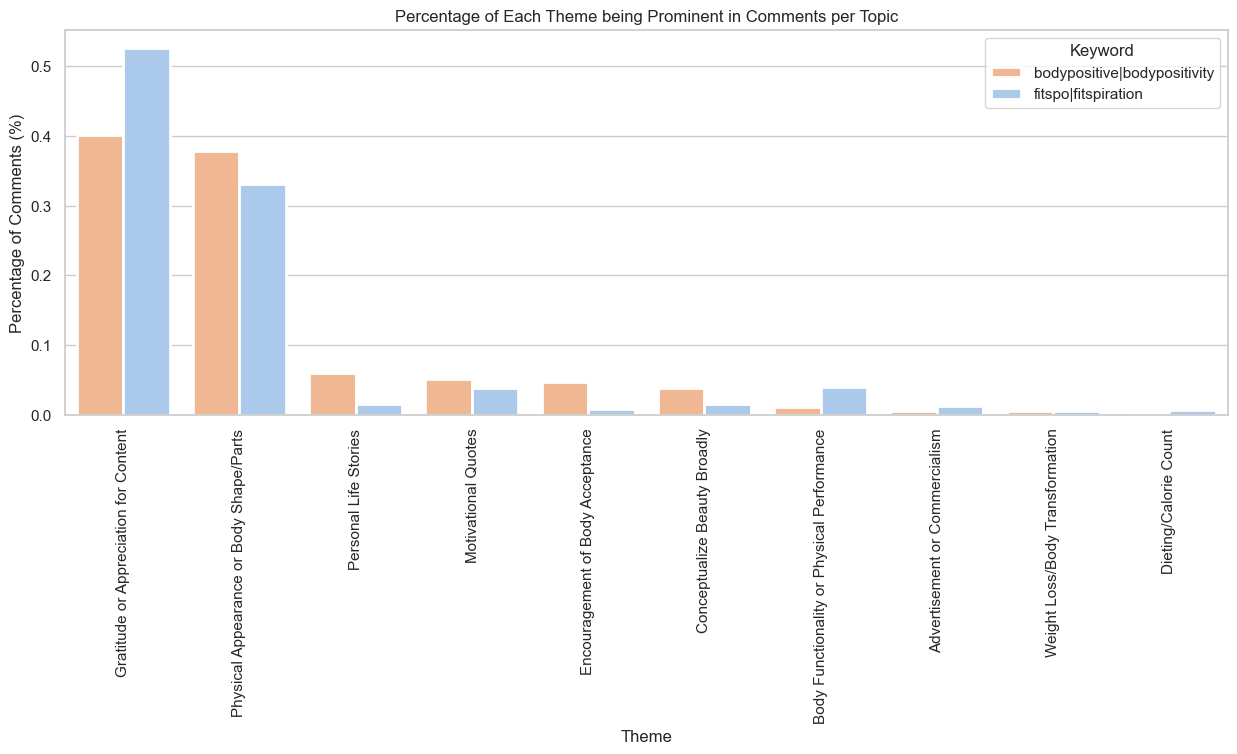

In [130]:
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_prominent_label['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='prominent_label', y='percentage', hue='keyword', data=df_prominent_label, ax=ax, palette=keyword_colors, linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(title='Keyword', loc='upper right')
ax.set_title('Percentage of Each Theme being Prominent in Comments per Topic')
ax.set_xlabel('Theme')
ax.set_ylabel('Percentage of Comments (%)')
plt.savefig('data/results/prominent_theme_percent_per_keyword.png')

In [87]:
# save examples that are labeled as prominent with each theme
for keyword in [FITSPO_Q, BODY_POSI_Q]:
    example_dict = {}

    for i in range(10):
        keyword_condition = df_comments['keyword'] == keyword
        label_condition = df_comments['prominent_label'] == TopicClassifier().comment_candidate_labels[i]
        comments = df_comments[keyword_condition & label_condition]['text'].sample(5).values
        example_dict[TopicClassifier().comment_candidate_labels[i]] = comments

    # create a dataframe
    df_examples = pd.DataFrame(example_dict)
    # add the keyword
    df_examples['keyword'] = keyword
    df_examples.to_excel(f'data/preprocessed_data/{keyword}_comment_label_examples.xlsx', index=False)


##### Percentage of each label being present

In [119]:
fitspo_avg_freq = df_comments[df_comments['keyword'] == FITSPO_Q].iloc[:, -11:-1].sum().sort_values(ascending=False) / len(df_comments[df_comments['keyword'] == FITSPO_Q])
body_posi_avg_freq = df_comments[df_comments['keyword'] == BODY_POSI_Q].iloc[:, -11:-1].sum().sort_values(ascending=False) / len(df_comments[df_comments['keyword'] == FITSPO_Q])

fitspo_df = pd.DataFrame(fitspo_avg_freq, columns=['percentage'])
body_posi_df = pd.DataFrame(body_posi_avg_freq, columns=['percentage'])

fitspo_df['keyword'] = FITSPO_Q
body_posi_df['keyword'] = BODY_POSI_Q

df_present_label = pd.concat([fitspo_df, body_posi_df])

df_present_label.reset_index(inplace=True)
df_present_label.rename(columns={'index': 'present_label'}, inplace=True)
df_present_label.sort_values(['keyword', 'percentage'], ascending=[True, False], inplace=True)

In [120]:
df_present_label

,present_label,percentage,keyword
10,Gratitude or Appreciation for Content,0.981868,bodypositive|bodypositivity
11,Physical Appearance or Body Shape/Parts,0.955108,bodypositive|bodypositivity
12,Motivational Quotes,0.278354,bodypositive|bodypositivity
13,Personal Life Stories,0.223459,bodypositive|bodypositivity
14,Conceptualize Beauty Broadly,0.222333,bodypositive|bodypositivity
15,Encouragement of Body Acceptance,0.163686,bodypositive|bodypositivity
16,Body Functionality or Physical Performance,0.077029,bodypositive|bodypositivity
17,Advertisement or Commercialism,0.023259,bodypositive|bodypositivity
18,Weight Loss/Body Transformation,0.021258,bodypositive|bodypositivity
19,Dieting/Calorie Count,0.006252,bodypositive|bodypositivity


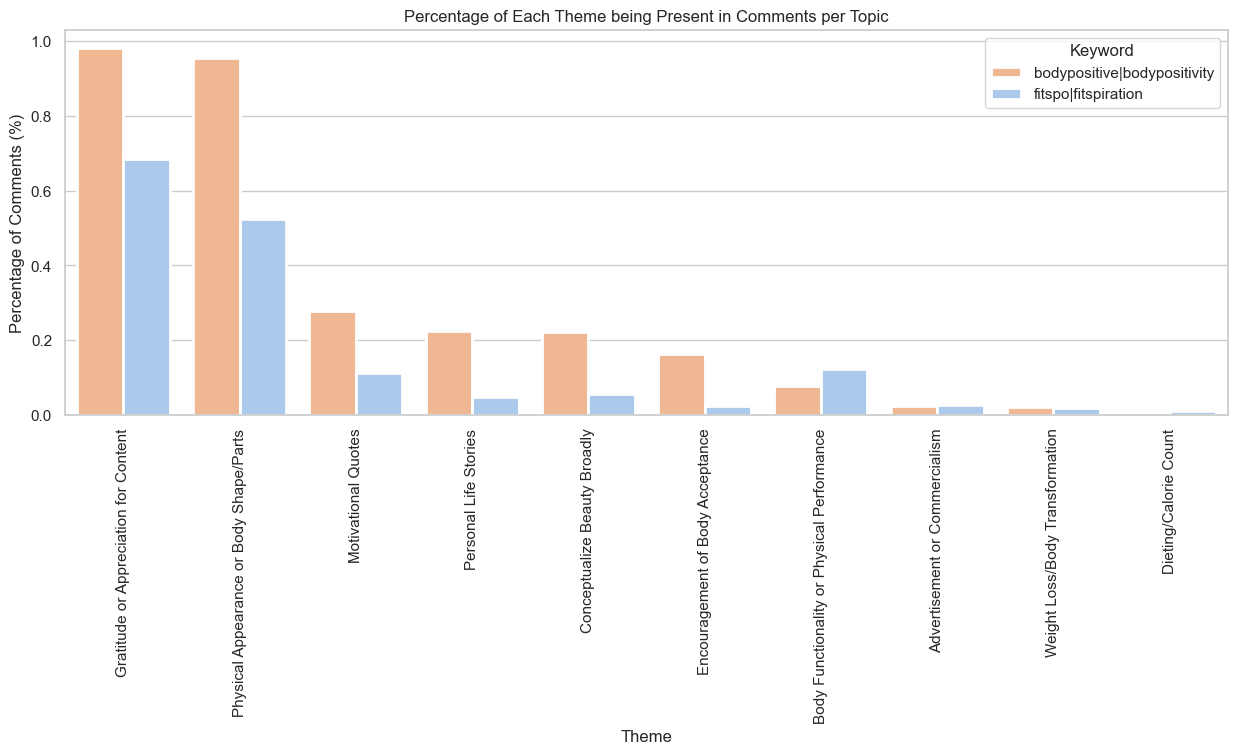

In [129]:
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_present_label['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='present_label', y='percentage', hue='keyword', data=df_present_label, ax=ax, palette=keyword_colors, linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(title='Keyword', loc='upper right')
ax.set_title('Percentage of Each Theme being Present in Comments per Topic')
ax.set_xlabel('Theme')
ax.set_ylabel('Percentage of Comments (%)')
plt.savefig('data/results/Present_theme_percent_per_keyword.png')